____
__Universidad Tecnológica Nacional, Buenos Aires__<br/>
__Ingeniería Industrial__<br/>
__Cátedra de Ciencia de Datos__<br/>
__Elaborado por: Francisco Lavaggi y Luciano De Doménico__<br/>
____

# Data Science: Predicción deserción de clientes Telco (Machine Learning)


En el presente trabajo práctico, se realizará:

- Un pipeline de __Machine Learning__ para predecir si un cliente se irá o no de la compañia.
- Aplicación de __reducción de la dimensionalidad__ (PCA).
- __Conclusiones__ del modelo



## 1. Carga de datos y pre-prosesamiento

Realizaremos algunos pasos similares a los desarrollados en el EDA:

In [ ]:
# Cargamos las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import warnings
warnings.filterwarnings('ignore')

url = "https://drive.google.com/uc?id=1Ooq9xb7_WQgX3U2AiKaelJphagUB52ZY" #Cargamos la url con el dataset de análisis
gdown.download(url, "telco_churn_clusterai.csv", quiet=False) # Usamos gdown para dercargarlo y cargarlo en un dataframe en el notebook

df = pd.read_csv("telco_churn_clusterai.csv", index_col= 1) #Leemos el dataframe con pandas

Downloading...
From: https://drive.google.com/uc?id=1Ooq9xb7_WQgX3U2AiKaelJphagUB52ZY
To: /content/telco_churn_clusterai.csv
100%|██████████| 958k/958k [00:00<00:00, 118MB/s]


A partir del EDA realizado anteriormente, podemos ver que hay columnas que no son necesarias y features que necesitan tratamiento.

In [ ]:
#Eliminamos la columna Unamed
df.drop('Unnamed: 0', axis=1, inplace=True)

# Modificamos el tipo de dato de 'TotalCharges' de object a float
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['SeniorCitizen'] = np.where(
    df['SeniorCitizen'] == 1, 'Yes',
    np.where(df['SeniorCitizen'] == 0, 'No', np.nan)
)
df['SeniorCitizen'] = df['SeniorCitizen'].replace('nan', np.nan)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,NaN,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,NaN,Electronic check,29.85,29.85,No
5575-GNVDE,Male,No,No,No,34.0,Yes,No,NaN,Yes,No,Yes,No,No,No,One year,No,Mailed check,NaN,1889.50,No
3668-QPYBK,Male,No,No,No,2.0,NaN,No,NaN,Yes,NaN,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,No,No,No,NaN,No,NaN,NaN,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,NaN,NaN,NaN,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,151.65,Yes


### 2. __Limpieza de datos__

En esta sección, vamos a identificar valores nulos, duplicados y simbolos que puedan estar ensuciado nuestra información

In [ ]:
#Quitamos duplicados
print("Cantidad de filas antes de duplicados", df.shape[0])

df.drop_duplicates(inplace=True, keep='first')
print("Cantidad de filas después de quitar duplicados", df.shape[0])

Cantidad de filas antes de duplicados 7043
Cantidad de filas después de quitar duplicados 7043


Decidimos reemplazar los valores NaN por la MODA (valor más frecuente) en los casos donde la variable es categórica y por la media en los casos donde la variable es numérica.


In [ ]:
#Rellenamos con la media los valores numéricos nulos
df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)

#Rellenamos con la moda los valores categóricos nulos
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

print("Valores nulos después de reemplazar:")
print(df.isnull().sum())

Valores nulos después de reemplazar:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### 3. Modelo de __Machine Learning__

Una vez realizado este análisis, procedemos a implementar un modelo de aprendizaje supervisado de Clasificación Lineal.

Los modelos de este tipo desarrollados durante el curso fueron:
- Suport Vector Machine
- KNN
- Logistic regresion

Empezaremos implmentando un SVM y testeando sus resultados.

In [ ]:
#Importamos las librerías de Machine Learning

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder

### 3.1. Obtenemos todos los __dummies__ de nuestras variables categóricas

In [ ]:
#Convertimos en "0" y "1" los valores de las muestras en features categóricos

df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies = df_dummies.astype(float)

df_dummies

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1.000000,29.850000,29.85,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5575-GNVDE,34.000000,64.658655,1889.50,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3668-QPYBK,2.000000,53.850000,108.15,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
7795-CFOCW,32.539742,42.300000,1840.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9237-HQITU,2.000000,64.658655,151.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,24.000000,64.658655,1990.50,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2234-XADUH,72.000000,103.200000,7362.90,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4801-JZAZL,11.000000,29.600000,346.45,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


### Separamos las features de la variable objetivo (Churn)

In [ ]:
# Separamos features y labels
X = df_dummies.drop(columns=['Churn_Yes'])
Y = df_dummies['Churn_Yes']

### Escalamos las variables con StandardScaler

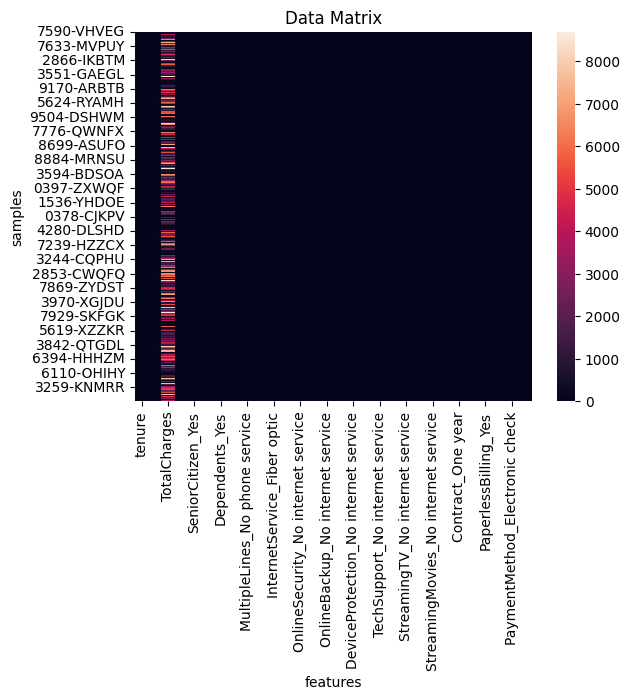

In [ ]:
# Graficamos los rangos de valores de cada variable con un heatmap

sns.heatmap(X)
plt.ylabel('samples')
plt.xlabel('features')
plt.title('Data Matrix')
plt.show()

##### Observamos que las variables no están en los mismos rangos. Posteriormente realizaremos un re-escalado.

### Dividimos el dataset en train y test


In [ ]:
# Dividimos los datos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(5634, 30)
(1409, 30)


Hacemos autoescaling solamente con el train:

In [ ]:
scaler = StandardScaler().fit(X_train)
scaler

StandardScaler()

In [ ]:
X_train_scaled = scaler.transform(X_train)
print(X_train_scaled.mean(axis=0)) #Media = 0
print(X_train_scaled.std(axis=0)) #Desvío estándard = 1

[ 6.43196300e-17  1.26116922e-17 -1.00262953e-16 -5.67526147e-17
  2.52233843e-18 -7.69313221e-17  5.04467686e-17  1.32422768e-16
  1.00893537e-17  1.76563690e-17 -8.32371682e-17 -2.77457227e-17
 -5.29691070e-17 -3.53127380e-17 -1.21072245e-16 -2.39622151e-17
 -7.31478145e-17 -3.78350765e-18 -7.31478145e-17  8.70206758e-17
 -7.31478145e-17  1.21072245e-16 -7.31478145e-17 -1.57646152e-17
  9.45876911e-18 -1.00893537e-17  1.57015567e-16  3.02680612e-17
  7.25172299e-17  5.92749531e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [ ]:
#Verificamos que la media y el std de test sean distintos de 0 y 1 para ver que el modelo no haya filtrado de datos de test
X_test_scaled = scaler.transform(X_test) #Usamos el Scaler con X_train al Xtest para que el modelo no aprenda del testing
print(X_test_scaled.mean(axis=0)) #Media distinta de 0
print(X_test_scaled.std(axis=0)) #Desvío estándard distinto de 1

[-0.00073002 -0.02060834 -0.01733349 -0.05170226  0.00241029 -0.01467756
 -0.00344445  0.02846973 -0.01536161  0.0056252  -0.00888249  0.01658369
  0.00799485  0.00060959  0.04159611 -0.0234262   0.01448653  0.01208024
  0.01448653  0.01190606  0.01448653 -0.02833058  0.01448653 -0.02101928
 -0.05439104  0.03962198 -0.00538223 -0.0187398   0.03962266 -0.01103597]
[1.02562825 1.00217097 1.00846991 1.0062499  1.00248896 0.99754117
 0.99811336 0.9568802  0.97678804 1.00155233 1.00017186 1.01292579
 1.00631564 1.00034591 1.03181987 0.9895526  1.00987119 1.00392193
 1.00987119 1.00545187 1.00987119 0.99300847 1.00987119 0.99502424
 0.95165838 1.02916788 1.00185261 0.98387678 1.00318219 0.99115932]


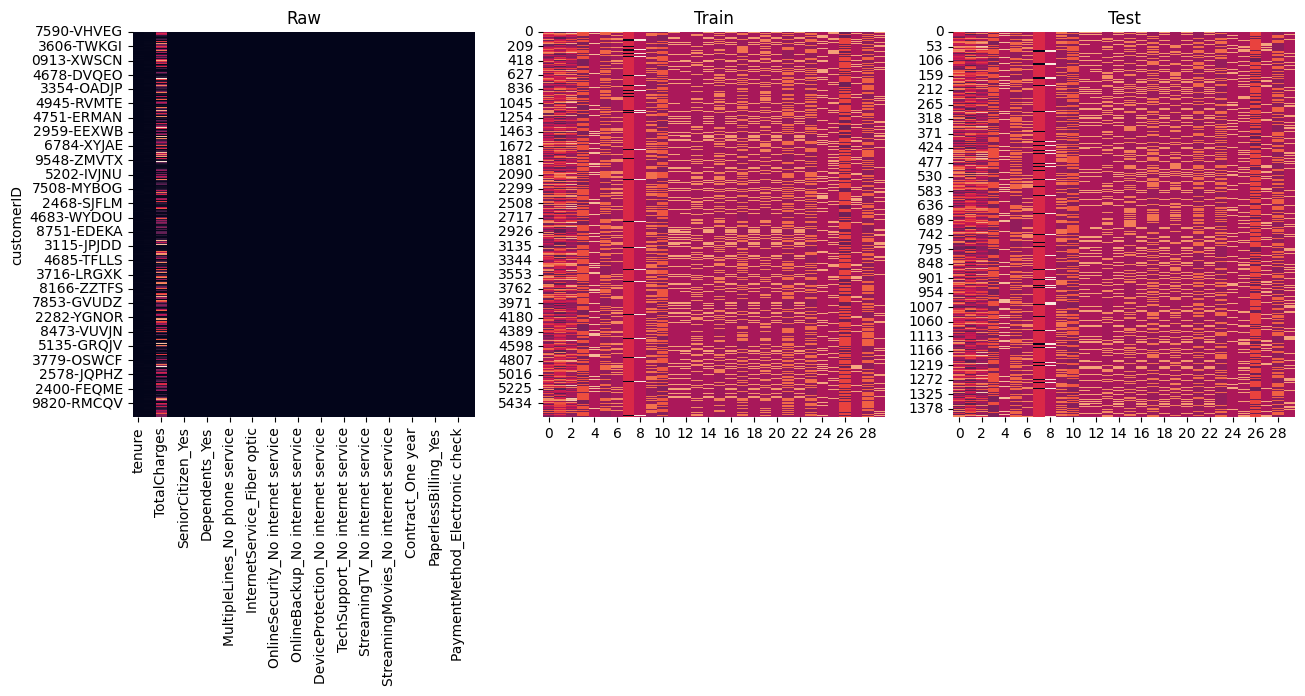

In [ ]:
#Visualizamos los rangos de valores de data "Raw", "Train" y "Test"
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(X, ax=axs[0], annot=False, cbar=False)  # Sin anotaciones
sns.heatmap(X_train_scaled, ax=axs[1], annot=False, cbar=False)
sns.heatmap(X_test_scaled, ax=axs[2], annot=False, cbar=False)

# Ajuste de títulos
axs[0].set_title('Raw')
axs[1].set_title('Train')
axs[2].set_title('Test')

plt.show()

Ya tenemos nuestros datos preprocesados, limpios, divididos en test y train y escalados.

### 4. Creamos el modelo __SVM__

Utilizamos GridSearchCV y SVM para clasificar si un cliente dejará la empresa o no.

#### GridSearchCV

In [ ]:
from sklearn import svm, datasets
from sklearn.svm import SVC
#Creamos el modelo Support Vector Classification (SVC)
svc = svm.SVC(probability=True)

#Hiperparámetros
parameters = {'kernel':('rbf', 'poly'),
              'C':[10, 1000],
              'gamma':[0.001, 0.01]}

clf = GridSearchCV(svc, # modelo
                   param_grid = parameters, # Hiperparametros
                   refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados
                   cv = 5, # cv indica la cantidad de folds
                   verbose=2)
clf.fit(X_train_scaled, Y_train.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   5.1s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   4.4s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   5.5s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   4.4s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   4.3s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   4.5s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   3.6s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   3.4s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   3.4s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   4.8s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   5.0s
[CV] END .......................C=10, gamma=0.01,

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [10, 1000], 'gamma': [0.001, 0.01],
                         'kernel': ('rbf', 'poly')},
             verbose=2)

*Aclaración: La GridSearch inicial tenía mayor cantidad de hiperparámetros, pero su tiempo de procesamiento era muy largo, por que lo que se optó por reducir la cantidad de los mismos, priorizando a los que dieron mejor resultado.

In [ ]:
# Imprimimos los resultados del entrenamiento
scores = clf.cv_results_
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

print("Los mejores hiperparámetros %s con un puntaje de %0.2f" % (clf.best_params_, clf.best_score_))

Los mejores hiperparámetros {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'} con un puntaje de 0.80


#### Planteamos la predicción sobre las muestras de testeo

In [ ]:
# Prediction sobre las muestras de test
Y_pred = clf.predict(X_test_scaled)
print(Y_pred)

# Model prediciton
print(clf.score(X_test_scaled,Y_test.ravel())) # Obtenemos el promedio de la accuracy

[0. 0. 0. ... 0. 0. 0.]
0.8176011355571328


In [ ]:
# Computamos el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(Y_test, Y_pred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.8176011355571328


### Graficamos la curva ROC

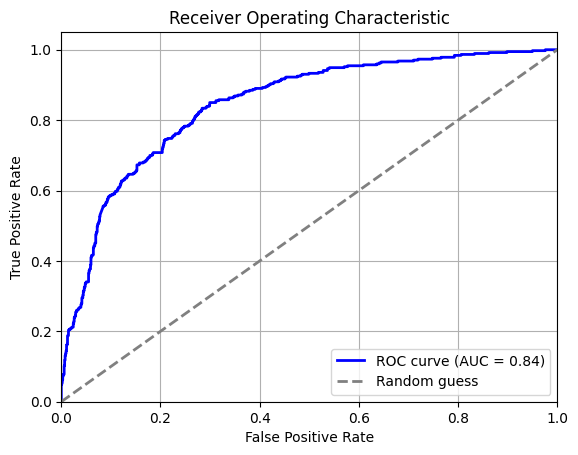

In [ ]:
# Calcular las probabilidades con el mejor modelo
y_scores = clf.best_estimator_.predict_proba(X_test_scaled)[:, 1]  # Clase positiva

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Confusion Matrix

Creamos la matriz para ver si el sistema clasifica erroneamente las clases:


[[943  93]
 [164 209]]


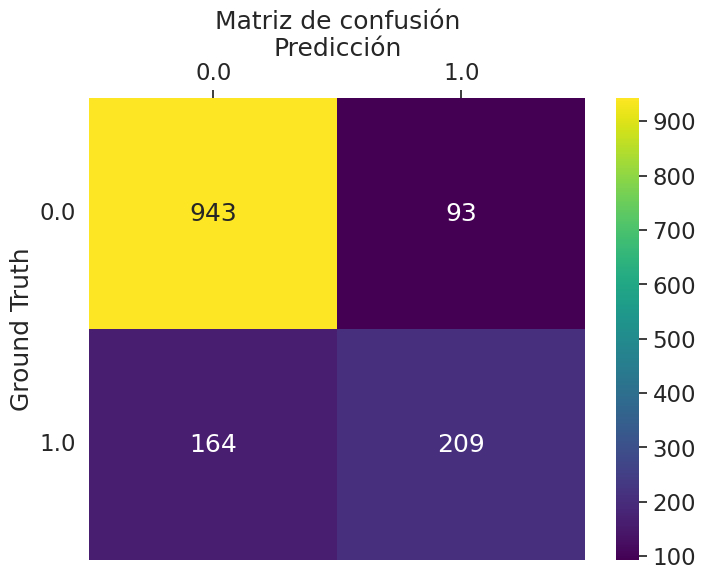

In [ ]:
# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
# Calcular la matriz de confusión
cm = confusion_matrix(Y_test, Y_pred)
print(cm)

# Crear un DataFrame para la matriz de confusión
df_cm = pd.DataFrame(cm,  # Valores
                     index=[i for i in np.unique(Y)],  # Filas
                     columns=[i for i in np.unique(Y)])  # Columnas

# Graficar el heatmap
sns.set(font_scale = 1.5)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df_cm, annot=True, fmt='d', cmap="viridis")  # fmt='d' para enteros
plt.yticks(rotation=0)
ax.xaxis.tick_top()  # Eje X en la parte superior
ax.xaxis.set_label_position('top')
plt.title('Matriz de confusión')
plt.xlabel("Predicción")
plt.ylabel("Ground Truth")
plt.show()

A partir del modelo de ML realizado, podemos concluir que entrenamos satisfactoriamente un SVM que permite predecir la deserción de clientes dadas una serie de features con un 80% de precisión.



## 5. __PCA__

A continuación vamos a aplicar una técnica de reducción de la dimensionalidad con el objetivo de simplificar el dataset original y re-entrenar al modelo para comparar los resultados de performance.

In [ ]:
# Importamos librerías de PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# cantidad de componentes a extraer
n_comps = 3
# definimos PCA
pca = PCA(n_components= n_comps)
# eliminamos columnas categóricas o binarias para aplicar PCA
columnas_excluir = [0,1,2]
X_train_pca = X_train_scaled[:, columnas_excluir]
# fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(X_train_pca))
# obtenemos los auto-valores (eigenvalues)
eigenvalues = pca.explained_variance_ratio_
var_acumulada = np.cumsum(eigenvalues)

In [ ]:
pca.explained_variance_

array([2.07255108, 0.80175151, 0.12622999])

In [ ]:
pca.explained_variance_ratio_

array([0.69072774, 0.26720307, 0.04206919])

In [ ]:
# El dataset se redujo de 30 a 3 dimensiones
print(f'Anteriores dimensiones del dataset: {X_train_scaled.shape}. Nuevas dimensiones, después de PCA: {xpca.shape}')

Anteriores dimensiones del dataset: (5634, 30). Nuevas dimensiones, después de PCA: (5634, 3)



Armamos un histograma con la varianza de cada uno de los 3 componentes principales (proyecciones) y su respectivo acumulado.



In [ ]:
#Creo una tabla para hacer el gráfico de la varianza del PCA
tabla_pca = pd.DataFrame({
    'Componente Principal': [f'PC{i+1}' for i in range(n_comps)],
    'Explained Variance': eigenvalues,
    'Varianza Acumulada': var_acumulada
})

tabla_pca

,Componente Principal,Explained Variance,Varianza Acumulada
0,PC1,0.690728,0.690728
1,PC2,0.267203,0.957931
2,PC3,0.042069,1.000000


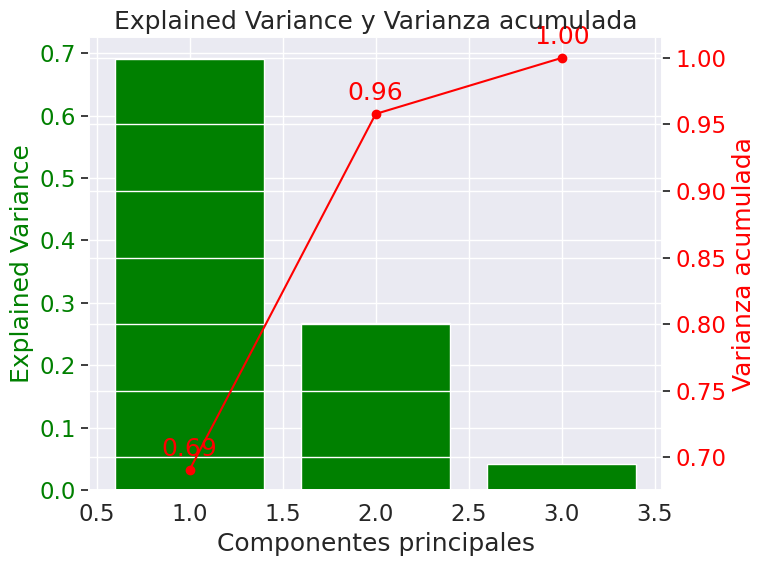

In [ ]:
components = range(1, n_comps + 1)

fig, ax1 = plt.subplots(figsize=(8, 6))

# Barras: Explained Variance
ax1.bar(components, eigenvalues, color='green', label='Explained Variance')
ax1.set_xlabel('Componentes principales')
ax1.set_ylabel('Explained Variance', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Línea: Varianza acumulada
ax2 = ax1.twinx()
ax2.plot(components, var_acumulada, color='red', marker='o', label='Varianza acumulada')
ax2.set_ylabel('Varianza acumulada', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Etiquetas para los valores acumulados
for x, y in zip(components, var_acumulada):
    ax2.annotate(f'{y:.2f}',
                 (x, y),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 color='red')

# Configuración del título
plt.title('Explained Variance y Varianza acumulada')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Observamos que los primeros dos componentes principales contienen el 96% de la varianza acumulada. A continuación graficamos la proyección en dicho par de ejes.

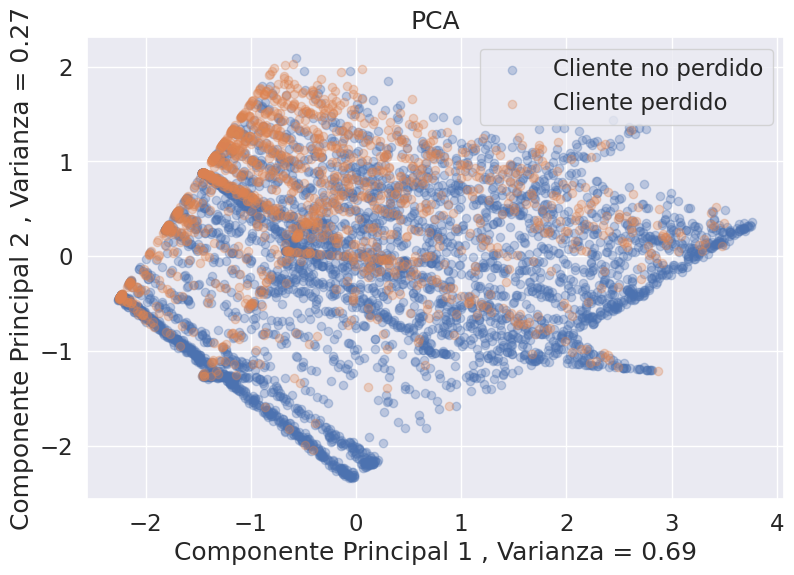

In [ ]:
# Generamos el scatterplot cada una de las muestras representadas en el par de ejes principales con sus respectivos labels
plt.figure(figsize=(9,6))
plt.scatter(xpca.loc[(Y_train == 0).ravel(),0],xpca.loc[(Y_train == 0).ravel(),1], alpha = 0.3, label = 'Cliente no perdido')
plt.scatter(xpca.loc[(Y_train == 1).ravel(),0],xpca.loc[(Y_train == 1).ravel(),1], alpha = 0.3, label = 'Cliente perdido')
plt.xlabel('Componente Principal 1 , Varianza = ' + str(np.round(eigenvalues[0],2)))
plt.ylabel('Componente Principal 2 , Varianza = ' + str(np.round(eigenvalues[1],2)))
plt.title('PCA')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Volvemos a entrenar al modelo, con los mismos hiperparametros que en el entrenamiento anterior, pero ahora con dimensionalidad reducida

clf = GridSearchCV(svc, # modelo
                   param_grid = parameters, # Hiperparametros
                   refit = True, # refit nos devuelve el modelo con los mejores parametros encontrados
                   cv = 5, # cv indica la cantidad de folds
                   verbose=2)
clf.fit(xpca, Y_train.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   2.9s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   2.7s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   4.3s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   2.8s
[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   2.8s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   1.4s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   1.3s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   1.4s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   2.5s
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time=   2.1s
[CV] END .......................C=10, gamma=0.01, kernel=rbf; total time=   2.5s
[CV] END .......................C=10, gamma=0.01,

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [10, 1000], 'gamma': [0.001, 0.01],
                         'kernel': ('rbf', 'poly')},
             verbose=2)

In [ ]:
# Imprimimos los resultados del entrenamiento
scores = clf.cv_results_
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

print("Los mejores hiperparámetros %s con un puntaje de %0.2f" % (clf.best_params_, clf.best_score_))

Los mejores hiperparámetros {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'} con un puntaje de 0.78


In [ ]:
#Aplicamos la misma transformación de PCA al set de prueba para poder predecir
X_test_pca = X_test_scaled[:,columnas_excluir]
x_test_pca = pca.transform(X_test_pca)

In [ ]:
# Prediction sobre las muestras de test
Y_pred = clf.predict(x_test_pca)

# Computamos el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(Y_test, Y_pred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.78708303761533


Obeservamos que el tiempo de procesamiento se reduce, y también el accuracy.

### 6. Prueba con __KNN__

Para ver si mejora la precisión, hacemos una breve prueba con el modelo KNN:


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Creamos el modelo KNN
knn = KNeighborsClassifier()

# Definimos los hiperparámetros a buscar
parameters = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Pesos para las distancias
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Métricas de distancia
}

# Configuramos el GridSearchCV
clf = GridSearchCV(knn,  # Modelo
                   param_grid=parameters,  # Hiperparámetros
                   refit=True,  # Refitting con los mejores parámetros
                   cv=5,  # Cross-validation
                   verbose=2)  # Verbosidad

# Entrenamos el modelo con los datos escalados
clf.fit(X_train_scaled, Y_train.ravel())

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.2s
[CV] END ...metric=euclidean, n_neighbors=5, we

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [ ]:
# Imprimimos los resultados del entrenamiento
scores = clf.cv_results_
scores_df = pd.DataFrame.from_dict(scores)
scores_df.head()

print("Los mejores hiperparámetros %s con un puntaje de %0.2f" % (clf.best_params_, clf.best_score_))

Los mejores hiperparámetros {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'} con un puntaje de 0.78


In [ ]:
# Prediction sobre las muestras de test
Y_pred = clf.predict(X_test_scaled)
print(Y_pred)

# Model prediciton
print(clf.score(X_test_scaled,Y_test.ravel())) # Obtenemos el promedio de la accuracY

[1. 0. 0. ... 0. 0. 0.]
0.7778566359119943


In [ ]:
# Computamos el accuracy (comparar ytest vs ypred)
test_acc = accuracy_score(Y_test, Y_pred)
print("El accuracy es " + str(test_acc))

El accuracy es 0.7778566359119943


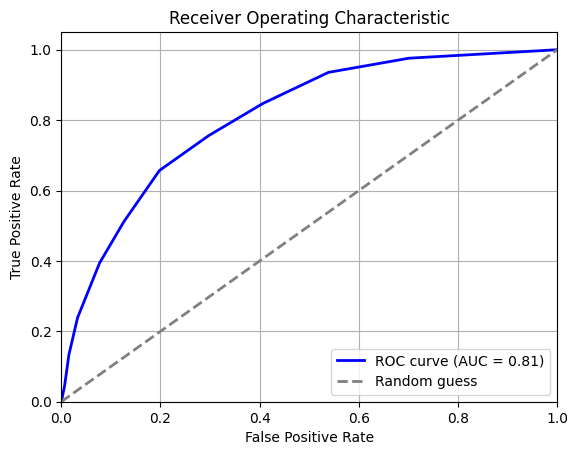

In [ ]:
# Calcular las probabilidades con el mejor modelo
y_scores = clf.best_estimator_.predict_proba(X_test_scaled)[:, 1]  # Clase positiva

# Calcular la curva ROC y el AUC
fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Obervamos que el modelo KNN da menos Acurracy que SVM, por lo que no profundizamos el analisis de este segundo modelo y optamos por predecir con SVM.